# Get CE rate as a function of M_gw emitting
author: [Mathieu Renzo](mrenzo@flatironinstitute.org)

In [1]:
import sys
# see https://github.com/mathren90/plotFunc
sys.path.append('/mnt/home/mrenzo/codes/python_stuff/plotFunc/')
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rc
from plotDefaults import *
import pandas as pd
import numpy as np
import os
import glob
from termcolor import colored
from COSMIClib import *
# parallelization stuff
from joblib import Parallel, delayed
import multiprocessing
import subprocess
import h5py

In [2]:
set_plotDefaults()

done in plotDefaults.py


In [3]:
# location of the simulation output
root = "/mnt/home/mrenzo/RUNS/CE_GW/CE_pop_synth/COSMIC/"
folders = sorted(glob.glob(root+"/qcrits*/"))
# print(folders)
default_folder = glob.glob(root+"qcrits_clayes/")[0]
# print(default_folder)

In [25]:
def getCErates_masscut(folder, SFR=3.5, Mcut = 10):
    # SFR is the assumed star formation rate in Msun/yr
    # folder contains the h5 frame output from cosmic-pop
    # Mcut the minimum GW emitting mass considered
    h5frame = glob.glob(folder+"*.h5")[0]
    bpp =  pd.read_hdf(h5frame, key='bpp') # key evolutionary changes
    total_mass = pd.read_hdf(h5frame, key='mass_stars')
    # total mass of the simulation
    Mtot = max(np.array(total_mass))[0]
    
    ## all CE events
    ## convert to astrophysical rate
    ## following https://cosmic-popsynth.github.io/docs/stable/fixedpop/index.html
    
    # get all CE event initiations
    iCEinit = bpp.evol_type == 7 # evol_type == 7 means beginning of CE event

    # select only a certain GW emitting mass
    ## N.B:  getGWemittingM(bpp, index) function is defined in COSMIClib.py
    Mgw = getGWemittingM(bpp, iCEinit)
    ## NB: Mgw has the length of iCEinit == True
    # print(len(Mgw),np.sum(iCEinit == 1),len(iCEinit))
    iMassive_enough = Mgw >= Mcut
    ## index = iCEinit * iMassive_enough
    index = iMassive_enough
    
    Nastro_CE = np.sum(index) # sum of all the CE events that are occurring
    Nastro_CE *= 1.0/Mtot # CE event occurring per unit mass of star formed [1/Msun]
    Nastro_CE *= SFR # [1/yr]

    ## only double core CE events
    # now lets get only the ones with a double core CE
    iCEdoublecore = (bpp.evol_type == 7) & ((bpp.kstar_1>1) & (bpp.kstar_2>1)) # CE initiation and both stars are post MS, so both have a core
    # print(np.sum(iCEdoublecore))

    Mgw = getGWemittingM(bpp, iCEdoublecore)
    iMassive_enough = Mgw >= Mcut
    # index_doublecore = iCEinit * iMassive_enough
    index_doublecore = iMassive_enough
    
    Nastro_CEdc = np.sum(index_doublecore) # sum of all the CE events that are occurring
    Nastro_CEdc *= 1.0/Mtot # CE event occurring per unit mass of star formed [1/Msun]
    Nastro_CEdc *= SFR # [1/yr]
    
    # print("number of double core (both post-MS) CE initiated per year:",Nastro_CEdc)
    # print("so every ~ %.0f"%float(1.0/Nastro_CEdc),"years a double core CE event starts in the Galaxy")
    # print("=============================================================================")
    return Nastro_CE, Nastro_CEdc

# Test
getCErates_masscut(default_folder, Mcut=-1)

(0.1774535049616231, 0.05540397485777042)

In [23]:
def getCErates_SepinitCut(folder, SFR=3.5, SepinitCut=1000):
    h5frame = glob.glob(folder+"*.h5")[0]
    bpp =  pd.read_hdf(h5frame, key='bpp') # key evolutionary changes
    # print(bpp.columns)
    total_mass = pd.read_hdf(h5frame, key='mass_stars')
    Mtot = max(np.array(total_mass))[0]

    iCEinit = bpp.evol_type == 7 # evol_type == 7 means beginning of CE event   
    iCEdoublecore = (bpp.evol_type == 7) & ((bpp.kstar_1>1) & (bpp.kstar_2>1)) # CE initiation and both stars are post MS, so both have a core
    
    Sep_CE = bpp.loc[iCEinit].sep
    Sep_CE_dc = bpp.loc[iCEdoublecore].sep

    iCE = iCEinit*(Sep_CE >= SepinitCut)
    Nastro_CE = np.sum(iCE) # sum of all the CE events that are occurring
    Nastro_CE *= 1.0/Mtot # CE event occurring per unit mass of star formed [1/Msun]
    Nastro_CE *= SFR # [1/yr]

    iCE_dc = iCEdoublecore*(Sep_CE_dc >= SepinitCut)
    Nastro_CEdc = np.sum(iCE_dc) # sum of all the CE events that are occurring
    Nastro_CEdc *= 1.0/Mtot # CE event occurring per unit mass of star formed [1/Msun]
    Nastro_CEdc *= SFR # [1/yr]

    return Nastro_CE, Nastro_CEdc

# Test
getCErates_SepinitCut(default_folder, SepinitCut=1000)

(0.016721683342804713, 0.002036615278931343)

In [24]:
print(default_folder)

/mnt/home/mrenzo/RUNS/CE_GW/CE_pop_synth/COSMIC/qcrits_clayes/


In [6]:
def getCErates_SepFinalCut(folder, SFR=3.5, SepFinalCut=1000):
    h5frame = glob.glob(folder+"*.h5")[0]
    bpp =  pd.read_hdf(h5frame, key='bpp') # key evolutionary changes
    # print(bpp.columns)
    total_mass = pd.read_hdf(h5frame, key='mass_stars')
    Mtot = max(np.array(total_mass))[0]

    iCEFinal = bpp.evol_type == 8 # evol_type == 8 means end of a CE event
    iCEdoublecore = (bpp.evol_type == 8) & ((bpp.kstar_1>1) & (bpp.kstar_2>1)) # CE Finaliation and both stars are post MS, so both have a core
    
    Sep_CE = bpp.loc[iCEFinal].sep
    Sep_CE_dc = bpp.loc[iCEdoublecore].sep

    iCE = iCEFinal*(Sep_CE >= SepFinalCut)
    Nastro_CE = np.sum(iCE) # sum of all the CE events that are occurring
    Nastro_CE *= 1.0/Mtot # CE event occurring per unit mass of star formed [1/Msun]
    Nastro_CE *= SFR # [1/yr]

    iCE_dc = iCEdoublecore*(Sep_CE_dc >= SepFinalCut)
    Nastro_CEdc = np.sum(iCE_dc) # sum of all the CE events that are occurring
    Nastro_CEdc *= 1.0/Mtot # CE event occurring per unit mass of star formed [1/Msun]
    Nastro_CEdc *= SFR # [1/yr]

    return Nastro_CE, Nastro_CEdc


In [ ]:
# plot rate of initiation as a function of the post-CE separation
fig = plt.figure(figsize=(15., 15.))
gs = gridspec.GridSpec(2,2)
gs.update(wspace=0,hspace=0)# top=1.1)
ax = plt.subplot(gs[0])

Sepcuts = np.linspace(0,3000, 101)
folders = ["/mnt/home/mrenzo/RUNS/CE_GW/CE_pop_synth/COSMIC/qcrits_0.1/",
           "/mnt/home/mrenzo/RUNS/CE_GW/CE_pop_synth/COSMIC/qcrits_1/",
           "/mnt/home/mrenzo/RUNS/CE_GW/CE_pop_synth/COSMIC/qcrits_2/",
           "/mnt/home/mrenzo/RUNS/CE_GW/CE_pop_synth/COSMIC/qcrits_clayes/",
           "/mnt/home/mrenzo/RUNS/CE_GW/CE_pop_synth/COSMIC/qcrits_clayes_Z0.002/",
           "/mnt/home/mrenzo/RUNS/CE_GW/CE_pop_synth/COSMIC/qcrits_indipendent_dist/"]
colors = plt.cm.viridis(np.linspace(0,1, len(folders)))
labels = [r"$q_c=0.1$", r"$q_c=1$", r"$q_c=2$", r"Clayes et al. 14 $q_c$", r"Clayes et al. 14 $q_c$, $Z=0.002$", r"Clayes et al. 14 $q_c$, indip. dist"]

for folder in folders:
    c = colors[folders.index(folder)]
    print("dealing with", folder, c)
    allCErate = []
    doublecoreCErate = []
    for Sepcut in Sepcuts:
        Rall, Rdoublecore = getCErates_SepFinalCut(folder, SFR=3.5, SepFinalCut=Sepcut)    
        allCErate.append(Rall)
        doublecoreCErate.append(Rdoublecore)
    #
    ax.plot(Sepcuts, allCErate, lw=3,c=c,ls='-')
    ax.plot(Sepcuts, doublecoreCErate, lw=3,c=c,ls='--')

ax.plot(np.nan, np.nan, lw=3,ls='-', c='k', label=r"all CE")
ax.plot(np.nan, np.nan, lw=3,ls='--',c='k', label=r"double core CE")
ax.plot(np.nan, np.nan, lw=3,ls='-', c='b', label=r"$qcrits=0.0001$")
ax.plot(np.nan, np.nan, lw=3,ls='-', c='#4477AA', label=r"$qcrits=0.1$")
ax.plot(np.nan, np.nan, lw=3,ls='-', c='#44AAAA', label=r"$qcrits=1$")
ax.plot(np.nan, np.nan, lw=3,ls='-', c='#44AA77', label=r"$qcrits=1000$")
ax.plot(np.nan, np.nan, lw=3,ls='-', c='#AAAA44', label=r"$qcrits=2$")
ax.plot(np.nan, np.nan, lw=3,ls='-', c='#AA7744', label=r"$qcrits=Clayes$")
ax.plot(np.nan, np.nan, lw=3,ls='-', c='#AA4455', label=r"$qcrits=Clayes, Z=0.002$")
ax.plot(np.nan, np.nan, lw=3,ls='-', c='#AA4488', label=r"$qcrits=Clayes, indip. dist$")
ax.plot(np.nan, np.nan, lw=3,ls='-', c='r', label=r"$qcrits=\infty$")

l=ax.legend(fontsize=30, loc="best", bbox_to_anchor=(1.05,1.05))
l.draw_frame(False)

# ax.set_xlabel(r"$\log_{10}(P_\mathrm{pre-CE}/ \mathrm{[days]})$", fontsize=30)
ax.set_xlabel(r"$\log_{10}(a_\mathrm{post-CE}/ \mathrm{[R_\odot]})$", fontsize=30)
ax.set_ylabel(r"$\mathrm{Initiation\ rate} \ [\mathrm{yr^{-1}}]$", fontsize=30)

ax.tick_params(axis='both', which='major', width=2, top="on", right="on", length=12, pad=10, labelsize=30, direction='in')
ax.tick_params(axis='both', which='minor', width=2, top="on", right="on", length=6, pad=10, direction='in')
# ax.xaxis.set_major_locator(MultipleLocator(20))
# ax.xaxis.set_minor_locator(MultipleLocator(10))
# ax.yaxis.set_major_locator(MultipleLocator(0.1))
# ax.yaxis.set_minor_locator(MultipleLocator(0.05))
# ax.set_xlim(1e-8,3000)
ax.set_yscale('log')
ax.set_xscale('log')
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
plt.tight_layout()
# plt.savefig("/mnt/home/mrenzo/TMP/CE_rate_func_post-CEsep.pdf")

dealing with /mnt/home/mrenzo/RUNS/CE_GW/CE_pop_synth/COSMIC/qcrits_0.1/


dealing with /mnt/home/mrenzo/RUNS/CE_GW/CE_pop_synth/COSMIC/qcrits_1/


dealing with /mnt/home/mrenzo/RUNS/CE_GW/CE_pop_synth/COSMIC/qcrits_2/



KeyboardInterrupt



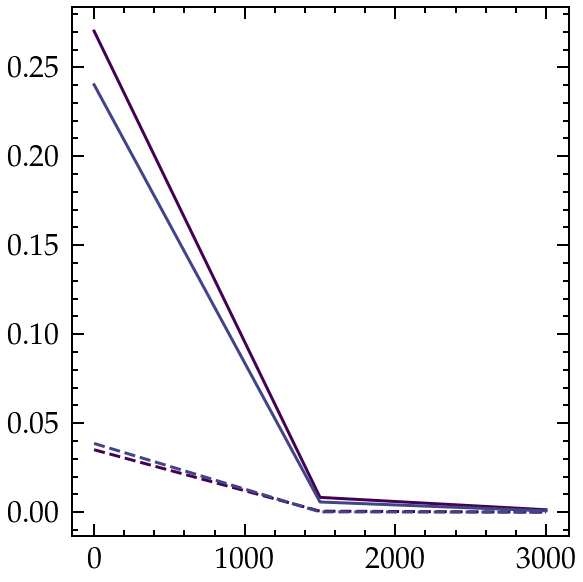

In [16]:
# plot rate of initiation as a function of the pre-CE separation

fig = plt.figure(figsize=(15., 15.))
gs = gridspec.GridSpec(2,2)
gs.update(wspace=0,hspace=0)# top=1.1)
ax = plt.subplot(gs[0])

Ntest = 3
Npaper = 101
Sepcuts = np.linspace(0, 3000, Ntest)

folders = ["/mnt/home/mrenzo/RUNS/CE_GW/CE_pop_synth/COSMIC/qcrits_0.1/",
           "/mnt/home/mrenzo/RUNS/CE_GW/CE_pop_synth/COSMIC/qcrits_1/",
           "/mnt/home/mrenzo/RUNS/CE_GW/CE_pop_synth/COSMIC/qcrits_2/",
           "/mnt/home/mrenzo/RUNS/CE_GW/CE_pop_synth/COSMIC/qcrits_clayes/",
           "/mnt/home/mrenzo/RUNS/CE_GW/CE_pop_synth/COSMIC/qcrits_clayes_Z0.002/",
           "/mnt/home/mrenzo/RUNS/CE_GW/CE_pop_synth/COSMIC/qcrits_indipendent_dist/"]
colors = plt.cm.viridis(np.linspace(0,1, len(folders)))
labels = [r"$q_c=0.1$", r"$q_c=1$", r"$q_c=2$", r"$\mathrm{Clayes\ et\ al.\ 14}\ q_c$", r"$\mathrm{Clayes\ et\ al.\ 14}\ q_c,\ Z=0.002$", r"$\mathrm{Clayes\ et\ al.\ 14}\ q_c,\ \mathrm{indip.\ dist}$"]

for folder in folders:
    c = colors[folders.index(folder)]
    label=labels[folders.index(folder)]
    print("dealing with", folder)
    allCErate = []
    doublecoreCErate = []
    for Sepcut in Sepcuts:
        Rall, Rdoublecore = getCErates_SepinitCut(folder, SFR=3.5, SepinitCut=Sepcut)    
        allCErate.append(Rall)
        doublecoreCErate.append(Rdoublecore)
    #
    ax.plot(Sepcuts, allCErate, lw=3,c=c,ls='-', label=label)
    ax.plot(Sepcuts, doublecoreCErate, lw=3,c=c,ls='--')

l=ax.legend(fontsize=20, loc="lower left", handletextpad=0.2, handlelength=0.75, ncol=2, columnspacing=0.5) #bbox_to_anchor=(1.05,1.05))
l.draw_frame(False)

p1, = ax.plot(np.nan, np.nan, lw=3,ls='-', c='k')
p2, = ax.plot(np.nan, np.nan, lw=3,ls='--',c='k')

l2=ax.legend([p1,p2],[r"$\mathrm{all\ CE}$",r"$\mathrm{both\ post\ MS}$"], fontsize=20,
             loc="center right", handletextpad=0.3, ncol=2,
             columnspacing=0.6, bbox_to_anchor=(0.7,0.3))
l2.draw_frame(False)

ax.add_artist(l)

# ax.set_xlabel(r"$\log_{10}(P_\mathrm{pre-CE}/ \mathrm{[days]})$", fontsize=30)
ax.set_xlabel(r"$\min(a_\mathrm{pre-CE})\ \mathrm{[R_\odot]}$", fontsize=30)
ax.set_ylabel(r"$R_\mathrm{CE,init} \ [\mathrm{yr^{-1}}]$", fontsize=30)

ax.tick_params(axis='both', which='major', width=2, top="on", right="on", length=12, pad=10, labelsize=30, direction='in')
ax.tick_params(axis='both', which='minor', width=2, top="on", right="on", length=6, pad=10, direction='in')
# ax.xaxis.set_major_locator(MultipleLocator(20))
# ax.xaxis.set_minor_locator(MultipleLocator(10))
# ax.yaxis.set_major_locator(MultipleLocator(0.1))
# ax.yaxis.set_minor_locator(MultipleLocator(0.05))
# ax.set_xlim(xmin=1e-50,xmax=3000)
ax.set_ylim(7e-6,3e-1)
ax.set_xlim(xmin=30, xmax=3100)
ax.set_yscale('log')
ax.set_xscale('log')
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
plt.tight_layout()
plt.savefig("/mnt/home/mrenzo/TMP/CE_rate_func_pre-CEsep_label.pdf", bbox_inches="tight")

dealing with /mnt/home/mrenzo/RUNS/CE_GW/CE_pop_synth/COSMIC/qcrits_0.1/


dealing with /mnt/home/mrenzo/RUNS/CE_GW/CE_pop_synth/COSMIC/qcrits_1/


dealing with /mnt/home/mrenzo/RUNS/CE_GW/CE_pop_synth/COSMIC/qcrits_2/


dealing with /mnt/home/mrenzo/RUNS/CE_GW/CE_pop_synth/COSMIC/qcrits_clayes/


dealing with /mnt/home/mrenzo/RUNS/CE_GW/CE_pop_synth/COSMIC/qcrits_clayes_Z0.002/


dealing with /mnt/home/mrenzo/RUNS/CE_GW/CE_pop_synth/COSMIC/qcrits_indipendent_dist/


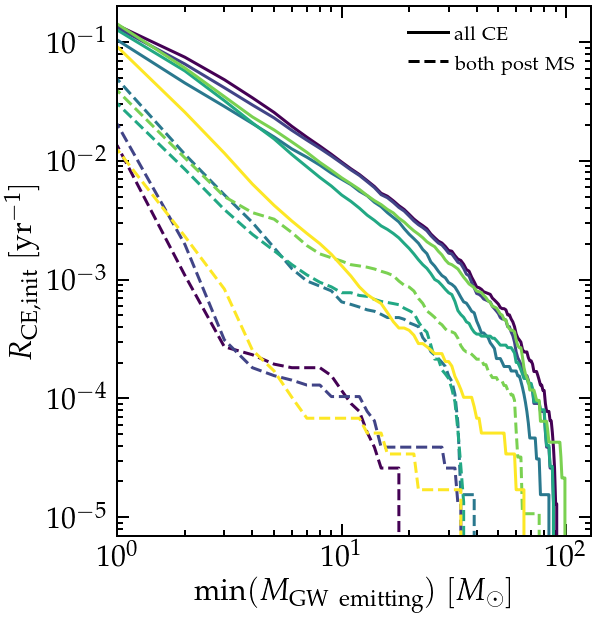

In [22]:
# plot rate of initiation as a function of the mass emitting GWs

fig = plt.figure(figsize=(15., 15.))
gs = gridspec.GridSpec(2,2)
gs.update(wspace=0,hspace=0)# top=1.1)
ax = plt.subplot(gs[0])

Ntest = 3
Npaper = 101
Mcuts  = np.linspace(0,100,Npaper)

folders = ["/mnt/home/mrenzo/RUNS/CE_GW/CE_pop_synth/COSMIC/qcrits_0.1/",
           "/mnt/home/mrenzo/RUNS/CE_GW/CE_pop_synth/COSMIC/qcrits_1/",
           "/mnt/home/mrenzo/RUNS/CE_GW/CE_pop_synth/COSMIC/qcrits_2/",
           "/mnt/home/mrenzo/RUNS/CE_GW/CE_pop_synth/COSMIC/qcrits_clayes/",
           "/mnt/home/mrenzo/RUNS/CE_GW/CE_pop_synth/COSMIC/qcrits_clayes_Z0.002/",
           "/mnt/home/mrenzo/RUNS/CE_GW/CE_pop_synth/COSMIC/qcrits_indipendent_dist/"]
colors = plt.cm.viridis(np.linspace(0,1, len(folders)))
labels = [r"$q_c=0.1$", r"$q_c=1$", r"$q_c=2$", r"$\mathrm{Clayes\ et\ al.\ 14}\ q_c$", r"$\mathrm{Clayes\ et\ al.\ 14}\ q_c,\ Z=0.002$", r"$\mathrm{Clayes\ et\ al.\ 14}\ q_c,\ \mathrm{indip.\ dist}$"]

for folder in folders:
    c = colors[folders.index(folder)]
    print("dealing with", folder)
    label = labels[folders.index(folder)]
    allCErate = []
    doublecoreCErate = []
    for Mcut in Mcuts:
        Rall, Rdoublecore = getCErates_masscut(folder, SFR=3.5, Mcut=Mcut)    
        allCErate.append(Rall)
        doublecoreCErate.append(Rdoublecore)
    #
    ax.plot(Mcuts, allCErate, lw=3,c=c,ls='-', label=label)
    ax.plot(Mcuts, doublecoreCErate, lw=3,c=c,ls='--')

# l=ax.legend(fontsize=20, loc="lower left", handletextpad=0.1, handlelength=0.7, ncol=1, columnspacing=0.5) #bbox_to_anchor=(1.05,1.05))
# l.draw_frame(False)

# p1, = ax.plot(np.nan, np.nan, lw=3,ls='-', c='k', label=r"all CE")
# p2, = ax.plot(np.nan, np.nan, lw=3,ls='--',c='k', label=r"both post MS")


l2=ax.legend([p1,p2],[r"$\mathrm{all\ CE}$",r"$\mathrm{both\ post\ MS}$"], fontsize=20,
             loc="upper right", handletextpad=0.3, ncol=1,
             columnspacing=0.6)# , bbox_to_anchor=(0.95,0.65))
l2.draw_frame(False)

# ax.add_artist(l)

ax.set_xlabel(r"$\min(M_\mathrm{GW\ emitting}) \ [M_\odot]$", fontsize=30)
ax.set_ylabel(r"$R_\mathrm{CE,init} \ [\mathrm{yr^{-1}}]$", fontsize=30)

ax.tick_params(axis='both', which='major', width=2, top="on", right="on", length=12, pad=10, labelsize=30, direction='in')
ax.tick_params(axis='both', which='minor', width=2, top="on", right="on", length=6, pad=10, direction='in')
ax.set_xlim(1,130)
ax.set_ylim(7e-6,2e-1)
# ax.xaxis.set_major_locator(MultipleLocator(20))
# ax.xaxis.set_minor_locator(MultipleLocator(10))
# ax.yaxis.set_major_locator(MultipleLocator(0.1))
# ax.yaxis.set_minor_locator(MultipleLocator(0.05))
ax.set_yscale('log')
ax.set_xscale('log')
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
plt.tight_layout()
plt.savefig("/mnt/home/mrenzo/TMP/CE_rate_Mgw_subset_label.pdf", bbox_inches="tight")

# ------------------------------------------------------------------------------------

In [ ]:
def typesMap(folder):
    fig = plt.figure(figsize=(15., 15.))
    gs = gridspec.GridSpec(2,2)
    gs.update(wspace=0,hspace=0)# top=1.1)
    ax = plt.subplot(gs[0])
    # read data
    h5frame = glob.glob(folder+"*.h5")[0]
    bpp =  pd.read_hdf(h5frame, key='bpp') # key evolutionary changes
    iCEinit = bpp.evol_type == 7 # evol_type == 7 means beginning of CE event   
    k1 = bpp.loc[iCEinit].kstar_1
    k2 = bpp.loc[iCEinit].kstar_2

    ax.scatter(k1, k2)
    ax.set_xlabel(r"k1",size=30)
    ax.set_ylabel(r"k2",size=30)
    ax.axvline(10,0,1)
    ax.axhline(10,0,1)
    ax.plot(np.linspace(0,15,2),np.linspace(0,15,2))
    ax.set_xlim(0,15)
    ax.set_ylim(0,15)

    ax.tick_params(axis='both', which='major', width=2, top="on", right="on", length=12, pad=10, labelsize=30, direction='in')
    ax.tick_params(axis='both', which='minor', width=2, top="on", right="on", length=6, pad=10, direction='in')

    ax.xaxis.set_major_locator(MultipleLocator(1))
    ax.yaxis.set_major_locator(MultipleLocator(1))
    # ax.xaxis.set_minor_locator(MultipleLocator(10))

    
# test
typesMap(default_folder)    